# 🐦 BirdPics: Computer Vision for migratory bird species recognition
Image classification project of European migratory bird species.

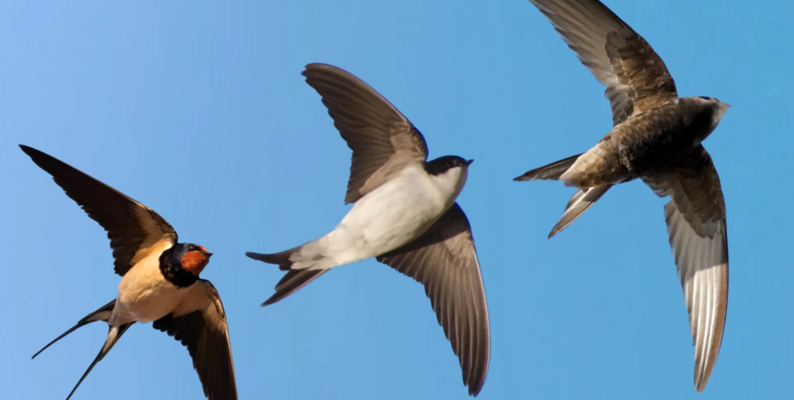

In this notebook, we will see how to download the 'BirdPics: migratory bird images' dataset through Kaggle's API. An explanation of the dataset and its structure will also be provided.

In this first version, the BirdPics datasets only includes images from three species: the common swallow (Hirunda rustica), the common swift (Apus apus) and the common house martin (Delichon urbicum), which are usual migratory species in Spain and Europe.

In [2]:
import kaggle
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

# Downloading the dataset

The dataset is uploaded in Kaggle as an hdf5 file. The following code creates a data folder and stores the data file there. 

Make sure you have your Kaggle API token properly configured. If you don't have any prior experience with Kaggle's API, please check the following tutorial: https://www.kaggle.com/getting-started/524433

In [4]:
kaggle.api.authenticate()
os.makedirs('data', exist_ok=True)
kaggle.api.dataset_download_files('jgbeniqu/birdpics-spanish-migratory-bird-image-dataset', path='./data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/jgbeniqu/birdpics-spanish-migratory-bird-image-dataset


# Loading and understanding the dataset

We use the h5py package to load the dataset:

In [3]:
# Please, run this cell only once to avoid running out of RAM memory
f = h5py.File('data/bird_data.hdf5', 'r')
print("Keys: %s" % f.keys())

Keys: <KeysViewHDF5 ['test', 'train', 'val']>


As we can see, there are three main groups in the dataset, corresponding to the training ('train'), validation ('val') and testing ('test') sets. Each one of these groups contains three files, named 'X', 'Y' and 'net_agreements'.

In [4]:
f_train = f['train'] # Accessing the training set
print("Keys: %s" % f_train.keys()) # Checking the keys in the training set

Keys: <KeysViewHDF5 ['X', 'Y', 'net_agreements']>


The 'X' file contains the 224x224 pixel RGB images, it is thus an array of shape (# of samples,224,224,3). The 'Y' file contains the species labels of each picture. Finally, the 'net_agreements' file contains the number of identification agreements minus the number of identification disagreements made by iNaturalist users as a way of rating the observation:

    Agreement Score = # of id. agreements - # of id. disagreements

This 'agreement score' was used as a filter while building the dataset, as pictures with a 'net_agreement' of zero or less were automatically excluded. They were included in the dataset as a rough estimation of the reliability of the observation and they may find further use in later versions of the project.

Anyway, the structure of the dataset is summarized in the following diagram

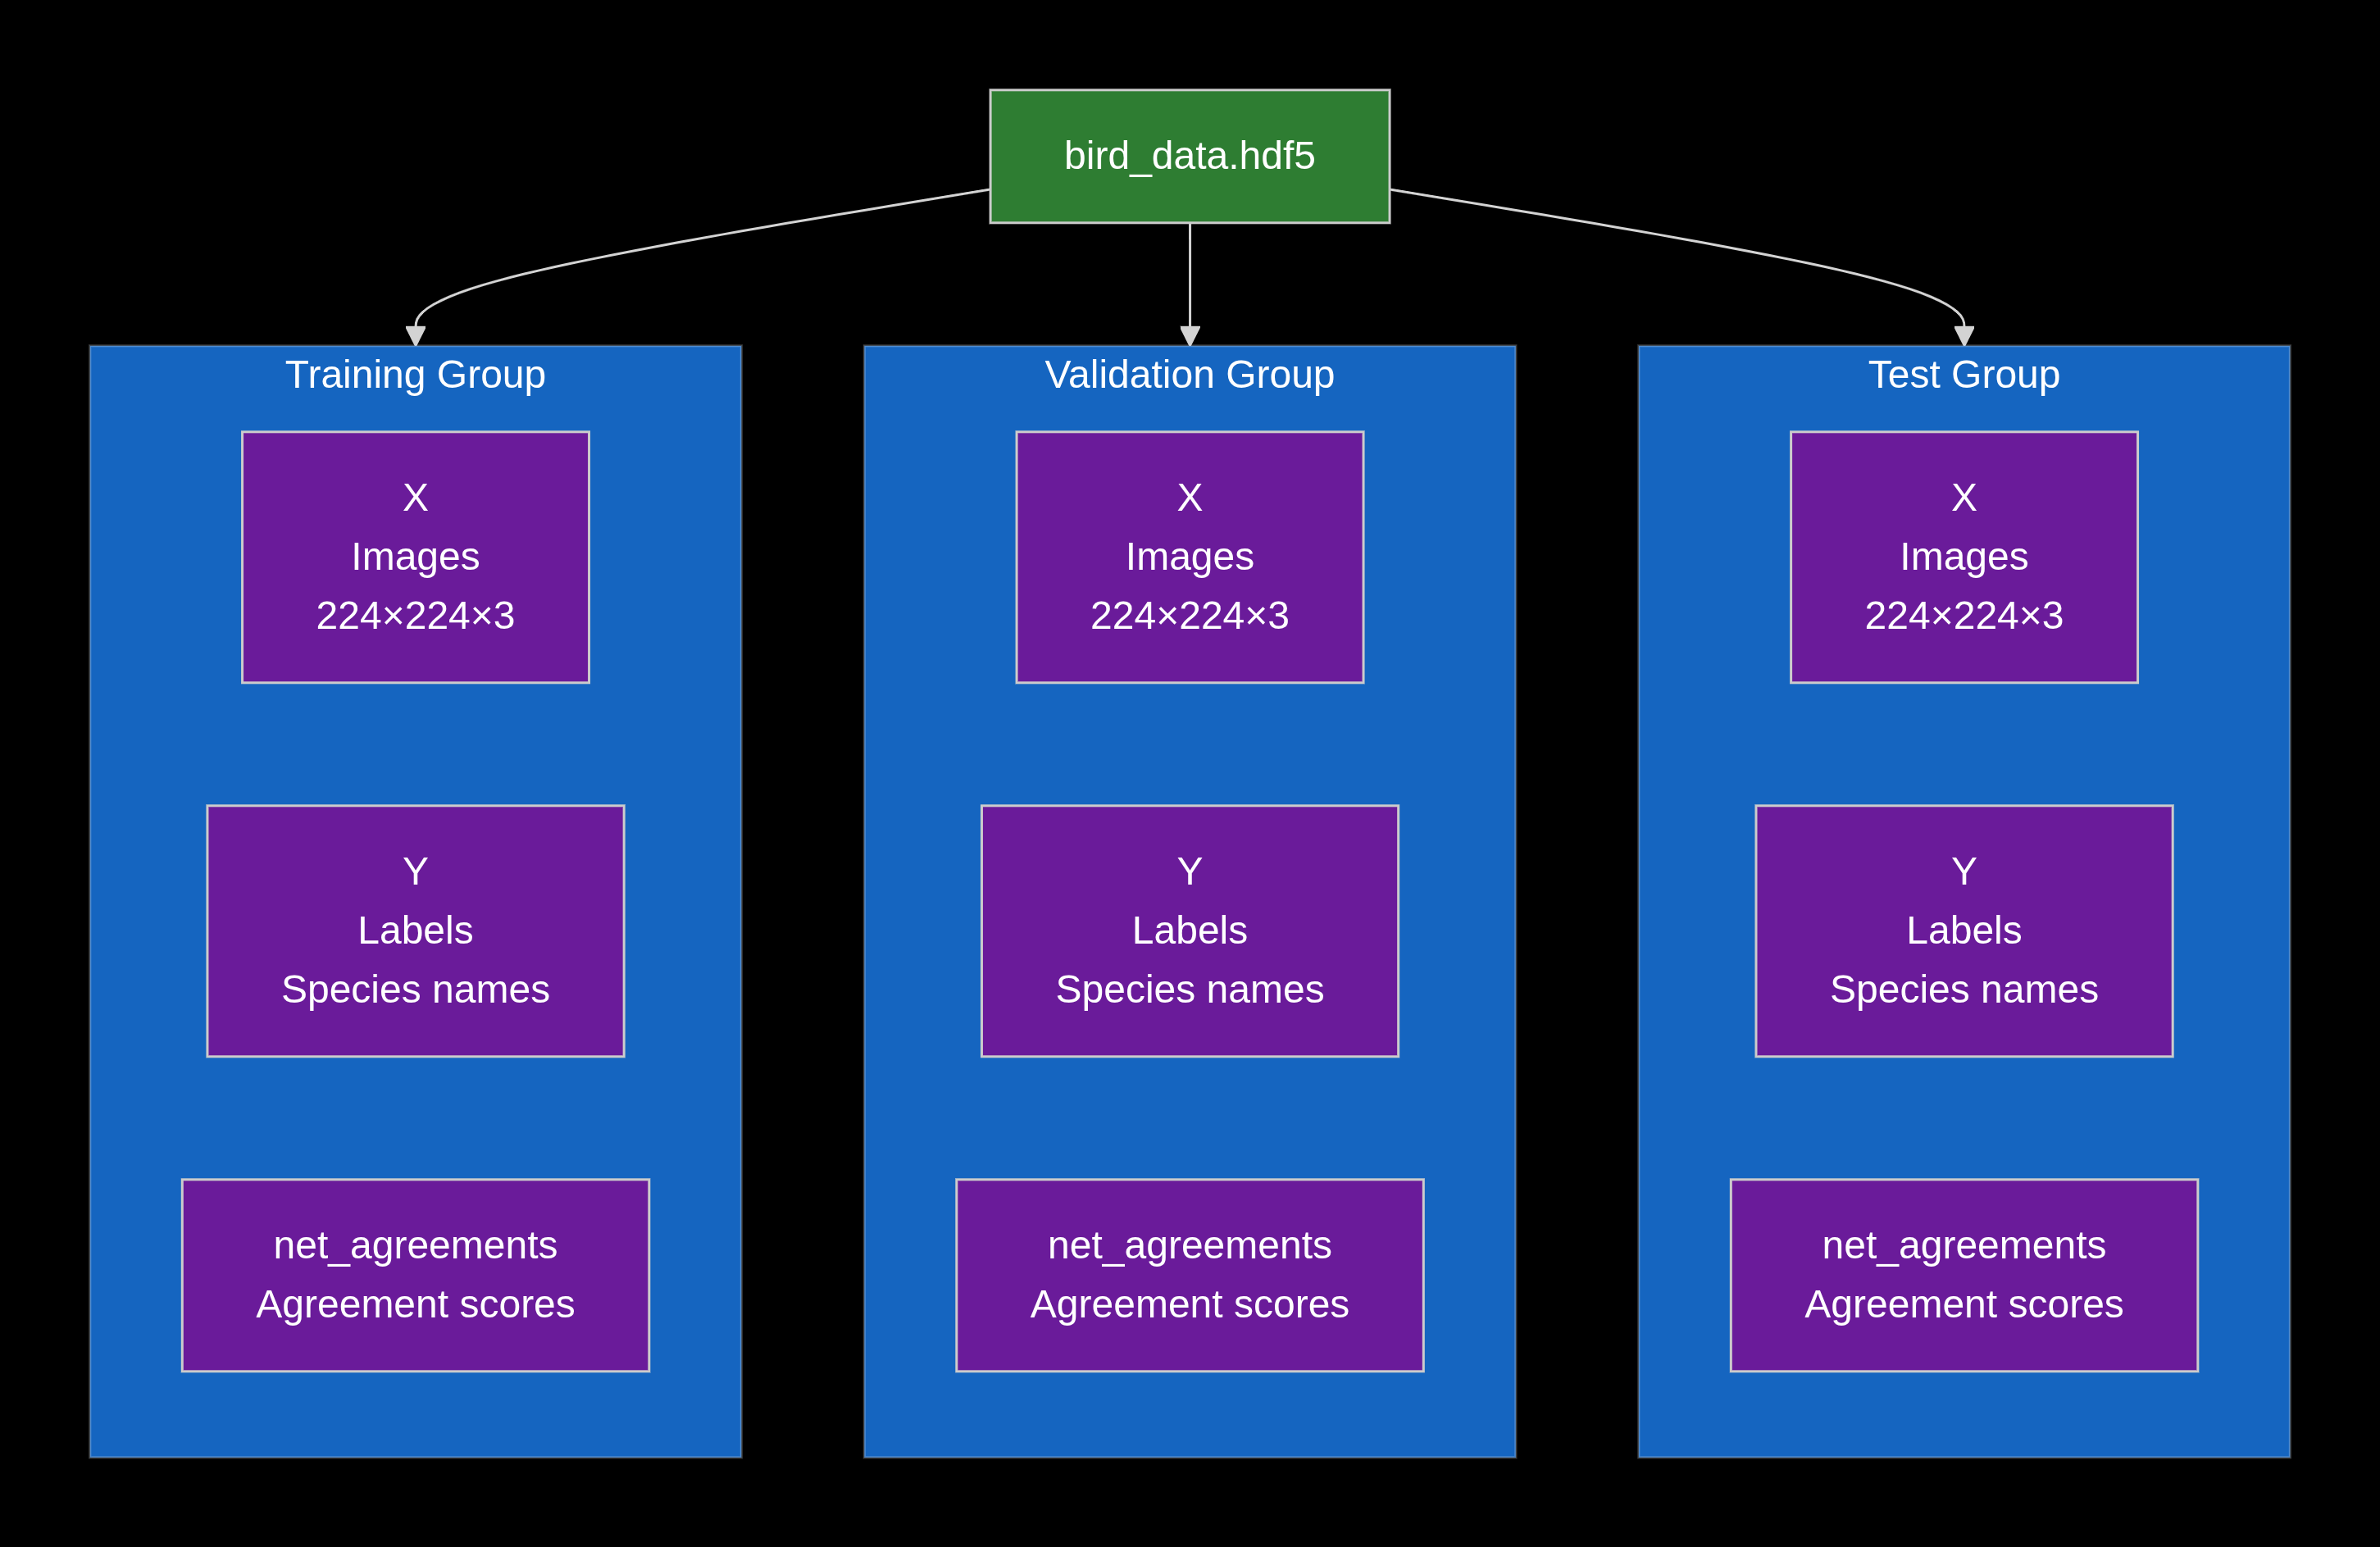

The train/val/test split was performed by random shuffling and splitting the complete dataset (24000 images). The training set comprises the 83% of the total (19920 samples); for the validation and test sets, each of them includes 8.5% of the remaining images (2040 samples each).

Let's take a brief look to the training set:

In [5]:
X_train, Y_train = f_train['X'], f_train['Y'] # Loading training data and labels
agree_train = f_train['net_agreements'] # Loading training agreement scores
print("Training data shape: ", X_train.shape)
print("Training labels shape: ", Y_train.shape)
print("Training agreements shape: ", agree_train.shape)

Training data shape:  (19920, 224, 224, 3)
Training labels shape:  (19920,)
Training agreements shape:  (19920,)


It is important to take into account that the labels are encoded in UTF-8 dtype, so they need to be decoded first: 

In [6]:
Y_train = np.array([y.decode('utf-8') for y in Y_train]) # Decoding labels from UTF-8 to string
print(Y_train[0:10])

['golondrina' 'golondrina' 'golondrina' 'avion' 'vencejo' 'avion' 'avion'
 'golondrina' 'avion' 'vencejo']


As you can see, the labels are written in Spanish. Their English counterpart would be
- golondrina = swallow (Hirunda rustica)
- vencejo = swift (Apus apus)
- avion = house martin (Delichon urbicum)

Let's implement a simple function for the translation:

In [7]:
def label_in_english(label_esp):
    if label_esp == 'golondrina':
        return 'swallow'
    elif label_esp == 'vencejo':
        return 'swift'
    elif label_esp == 'avion':
        return 'house martin'
    else:
        return 'unknown'

And now let's plot a small sample of the dataset:

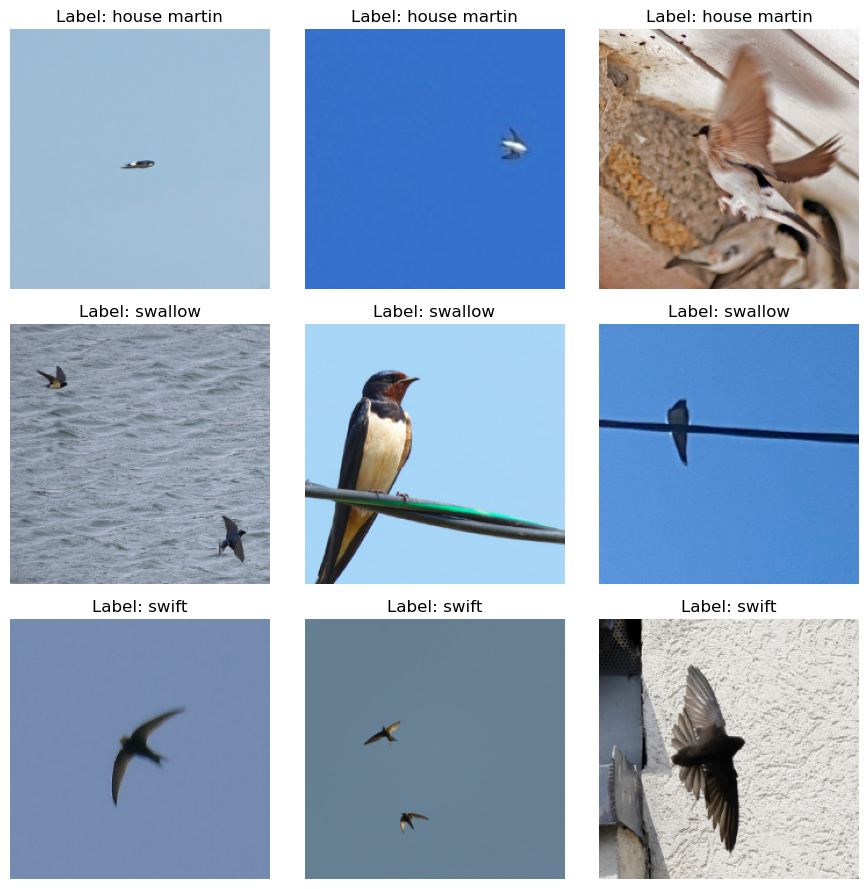

In [9]:
# Set random seed for reproducibility
seed = 0
np.random.seed(seed)

# Visualize some samples from each class
labels = np.unique(Y_train) # list of unique labels

fig,ax = plt.subplots(3, 3, figsize=(9, 9)) 
for i in range(len(labels)):
    idx = np.where(Y_train == labels[i])[0] # indices of samples with the current label
    random_sample = np.random.choice(idx, size=3, replace=False) # randomly select 3 samples
    X = X_train[np.sort(random_sample)] # get the images for the selected samples
    for j in range(3):
        ax[i, j].imshow(X[j]) # display the image
        ax[i, j].axis('off')
        ax[i, j].set_title(f"Label: {label_in_english(labels[i])}") # set title with English label
plt.tight_layout()
plt.show()

## Brief discussion of the cleaning process

The objective when building the dataset was to isolate pictures of the birds themselves (either flying, perched, lying on the ground, etc). For that, some undesired pictures had to be removed during the cleaning process. Examples of images unsuitable for the dataset were pictures of feathers, and pictures where the birds were not recognizable. 

An automated cleaning procedure was conducted using CLIP (OpenAI). In it, each image was turned to text and compared to some preestablished tokens such as 'perched bird', 'flying bird', 'feather' or 'building' to determined if it was kept in the dataset or discarded (code to be provided in a later version). This procedure discarded around 10% of the initial dataset and was implemented before the train/val/test split.

A sample of discarded images has been stored as 'discarded_sample.npy'. Here we provide a visualization of those discarded images:

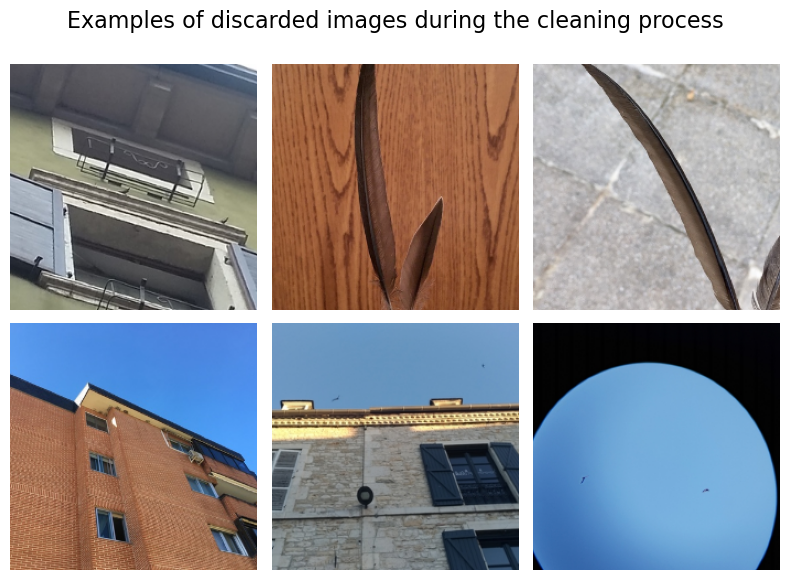

In [9]:
discarded_imgs = np.load('./other_files/discarded_sample.npy')
fig, ax = plt.subplots(2, 3, figsize=(8, 6))
for i in range(len(discarded_imgs)):
    ax[i // 3, i % 3].imshow(discarded_imgs[i])
    ax[i // 3, i % 3].axis('off')
plt.suptitle('Examples of discarded images during the cleaning process', fontsize=16)
plt.tight_layout()
plt.show()

The procedure was not perfect, and some undesired images were kept in the dataset (and viceversa). However, it significantly improved the quality of the pictures in the final dataset.

In the next notebook ('N2_image_preprocessing.ipynb'), we will discuss the data augmentation techniques that were used to train the classification models.